## Feature Selection

Credits: <br>
1. https://www.kaggle.com/tilii7/recursive-feature-elimination/comments <br>
2. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import gc
import time

## Prepare data frame of the extracted features

In [3]:
# Load target feature
train=pd.read_csv('inputs/train.csv')
loss=train.loss
del train
gc.collect()

# load engineered features
features=pd.read_csv('inputs/features.csv')
features=features[features.columns[1:]]

# Downcast dataframe to save RAM.
# credit:https://www.kaggle.com/anshuls235/m5-forecasting-eda-fe-modelling
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

start=time.time()
features=downcast(features)
loss=downcast(pd.DataFrame(loss))
end=time.time()
print('Execution time in minutes:',(end-start)/60)
loss=np.ravel(loss)

Execution time in minutes: 4.324980962276459


## Recurrsive feature elimination with cross validation (RFECV) <br>
Recursive feature elimination (RFE) method is a recurrsive method to eliminate least improtant features. It does so by calculating feature importance of the predictor features by predicting target values using a user defined machine learning model. At every step RFE class removes the least important feature untill a user defined number of features are left. On the other hand recurrsive feture elimination with cross validation (RFECV) automatically selects optimal number of features by making use of the cross validation score. <br>
#### Estimator:
For this problem we use random forest regressor(RFR) as our estimator. Paramter of RFR are:
<ol>
    <li>Number of estimators (decision trees): 100</li>
    <li>Maximum depth of any tree: 12</li>
    <li>Maximum number of features when looking for the best split: $\text{n_features}^{1/2}$</li>
</ol>

#### RFECV:
<ol>
    <li>Estimator: Random forest regressor</li>
    <li>Number of features to eliminate at each iteration: 10</li>
    <li>Cross validation method: 5 fold</li>
    <li>Scoring funciton: Mean absolute error</li>
</ol>

In [4]:
# Define the estimator: random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=12, n_jobs=-1)

In [5]:
rfecv = RFECV(estimator=rfr,
              step=10,
              cv=KFold(n_splits=10,
                       shuffle=False),
              scoring='neg_mean_absolute_error',
              verbose=2,
             n_jobs=-1)

start=time.time()
rfecv.fit(features,loss)
end=time.time()
print('Execution time in hrs:',(end-start)/3600)

Fitting estimator with 1464 features.
Fitting estimator with 1454 features.
Fitting estimator with 1444 features.
Fitting estimator with 1434 features.
Fitting estimator with 1424 features.
Fitting estimator with 1414 features.
Fitting estimator with 1404 features.
Fitting estimator with 1394 features.
Fitting estimator with 1384 features.
Fitting estimator with 1374 features.
Fitting estimator with 1364 features.
Fitting estimator with 1354 features.
Fitting estimator with 1344 features.
Fitting estimator with 1334 features.
Fitting estimator with 1324 features.
Fitting estimator with 1314 features.
Fitting estimator with 1304 features.
Fitting estimator with 1294 features.
Fitting estimator with 1284 features.
Fitting estimator with 1274 features.
Fitting estimator with 1264 features.
Fitting estimator with 1254 features.
Fitting estimator with 1244 features.
Fitting estimator with 1234 features.
Fitting estimator with 1224 features.
Fitting estimator with 1214 features.
Fitting esti

### Model performance for number of features

 Optimal number of features: 264


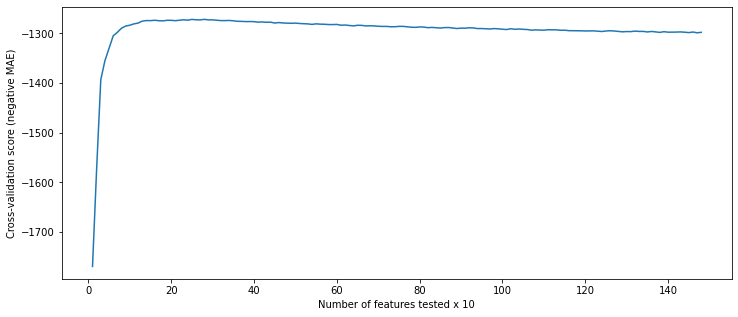

In [7]:
print(' Optimal number of features: %d' % rfecv.n_features_)
fig,ax=plt.subplots(figsize=(12,5))
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax.set_xlabel('Number of features tested x 10')
ax.set_ylabel('Cross-validation score (negative MAE)',fontsize=10)
plt.savefig('Allstate-RFECV.png')
plt.show();

### Save feature selection data frame

In [8]:
all_features=features.columns
sel_features = [f for f, s in zip(all_features, rfecv.support_) if s]
ranking = pd.DataFrame({'Features': all_features})
ranking['Rank'] = np.asarray(rfecv.ranking_)
ranking.sort_values('Rank', inplace=True)
ranking.to_csv('inputs/Allstate-RFECV-ranking.csv', index=False)
print(' Ranked features saved:  Allstate-RFECV-ranking.csv')
score = round(-np.max(rfecv.grid_scores_), 3)
print('Best score:',score)

 Ranked features saved:  Allstate-RFECV-ranking.csv
Best score: 1271.572
